In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import datetime
import random
import torch


from transformers import BertForSequenceClassification, BertConfig
from sklearn.metrics import f1_score

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
from transformers import BertTokenizer
from my_model import CustomModel 

There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [3]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [4]:
def add_spaces(seq):
     return ' '.join(list(seq))

Данные по альфа и бета цепи из реальных доноров

In [5]:
alpha_data = pd.read_csv('nlp_tcr_predictor/data/selected_cdr_alpha_440002200808_S159_L002.csv', index_col=0)
beta_data = pd.read_csv('nlp_tcr_predictor/data/selected_cdr_beta_440001980101_S87_L001.csv', index_col=0)

In [6]:
alpha_data['type'] = 0
alpha_data.head()
print(f'Dataset of alpha chain size {alpha_data.shape}')

beta_data['type'] = 1
beta_data.head()
print(f'Dataset of beta chain size {beta_data.shape}')

Dataset of alpha chain size (23065, 4)
Dataset of beta chain size (34345, 5)


In [7]:
compl_df = pd.concat([alpha_data[['cdr3aa', 'type']], beta_data[['cdr3aa', 'type']]], ignore_index=True)

In [7]:
compl_df

,cdr3aa,type
0,CAETRGAGNMLTF,0
1,CAGNTGGFKTIF,0
2,CAVEDGQKLLF,0
3,CAVSEPFGNEKLTF,0
4,CATDPNTGNQFYF,0
...,...,...
57405,CASSLRPQHF,1
57406,CASSDVGYTF,1
57407,CASRGVGYTF,1
57408,CSASFVTQYF,1


In [8]:
compl_df['cdr3aa'] = compl_df['cdr3aa'].map(add_spaces)

<BarContainer object of 2 artists>

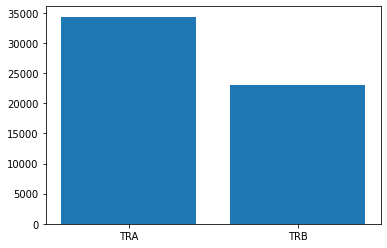

In [9]:
plt.bar(['TRA', 'TRB'], compl_df['type'].value_counts())

There is slight imbalance in the number of objects in the TRA and TRB classes, but probably it won't affect the model quality, because all the classes have enougth observations 

In [9]:
test_dataset = compl_df.sample(frac=0.15)
compl_df = compl_df.drop(test_dataset.index)
compl_df = compl_df.reset_index(drop=True)
compl_df.head()

,cdr3aa,type
0,C A E T R G A G N M L T F,0
1,C A G N T G G F K T I F,0
2,C A V E D G Q K L L F,0
3,C A V S E P F G N E K L T F,0
4,C A F L N N A G N M L T F,0


In [10]:
ans = test_dataset['type']
test_dataset = test_dataset.drop(columns=['type'])
test_dataset = test_dataset.reset_index(drop=True)

# TCR transformer model

In [12]:
tokenizer = BertTokenizer.from_pretrained("wukevin/tcr-bert", do_lower_case=False )

In [13]:
print(' Original: ', alpha_data.iloc[0, 0])
print('Tokenized: ', tokenizer.tokenize(compl_df.iloc[0, 0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(compl_df.iloc[0, 0])))

 Original:  CAETRGAGNMLTF
Tokenized:  ['C', 'A', 'E', 'T', 'R', 'G', 'A', 'G', 'N', 'M', 'L', 'T', 'F']
Token IDs:  [9, 13, 4, 6, 0, 11, 13, 11, 7, 17, 16, 6, 18]


In [14]:
max_len = 0
for seq in compl_df['cdr3aa']:
    input_ids = tokenizer.encode(seq, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max seq length: ', max_len)

Max seq length:  22


In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [18]:
tcr_bert_tokenizer = BertTokenizer.from_pretrained("wukevin/tcr-bert", do_lower_case=False );
tcr_bert_model = BertForSequenceClassification.from_pretrained("wukevin/tcr-bert",
    num_labels = 2,
    ignore_mismatched_sizes=True,
    output_attentions = False,
    output_hidden_states = False);

tcr_bert_model.cuda();

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
my_model = CustomModel(tcr_bert_tokenizer, tcr_bert_model);

In [20]:
input_ids, attention_masks, labels = my_model.tokenize(compl_df['cdr3aa'], compl_df['type']);

print('Original: ', compl_df.iloc[0, 0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  C A E T R G A G N M L T F
Token IDs: tensor([25,  9, 13,  4,  6,  0, 11, 13, 11,  7, 17, 16,  6, 18, 24, 21, 21, 21,
        21, 21, 21, 21])


In [21]:
train_dataset, val_dataset = my_model.split_data(input_ids, attention_masks, labels)

39,038 training samples
9,760 validation samples


In [33]:
my_model.fit(train_dataset, val_dataset)


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:02:05

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.00
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:02:04

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.00
  Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:02:04

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.00
  Validation took: 0:00:05

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:01:50

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.00
  Validation took: 0:00:05

Training complete!


In [34]:
my_model.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.008419,0.001410,0.999795,0:02:05,0:00:05
2,0.002827,0.000634,0.999795,0:02:04,0:00:05
3,0.001181,0.000693,0.999795,0:02:04,0:00:05
4,0.000513,0.000004,1.000000,0:01:50,0:00:05


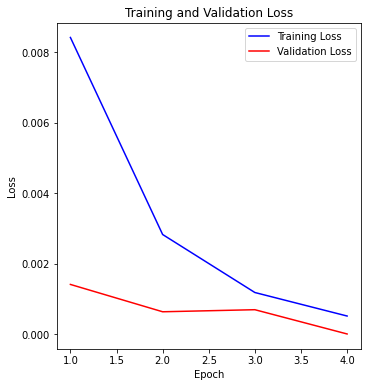

In [35]:
my_model.draw_stats_plot()

In [36]:
pred_labels = my_model.predict(test_dataset['cdr3aa'])

/home/akabalina/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [40]:
f1_sc = f1_score(ans, pred_labels)
print('Total f1_score: %.5f' % f1_sc)

Total f1_score: 0.99971


# ProtTrans model

In [ ]:
from transformers import T5Tokenizer, T5EncoderModel

tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)

# Load the model
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to(device)

my_model = CustomModel(tcr_bert_tokenizer, tcr_bert_model)

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

In [24]:
pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.3 MB 2.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [31]:
import sentencepiece as spm

In [27]:
pip install protobuf

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
test_dataset

,cdr3aa
0,C A S S L A G A G P Y N E Q F F
1,C A S S F Q G T S S Y Y T F
2,C A I G I A G G N E Q F F
3,C A S S L A A S G G R Y T Q Y F
4,C A L A S Y G N N R L A F
...,...
8607,C A S S V L R G P G F D T Q Y F
8608,C I V G P I G S S N T G K L I F
8609,C A S S P L Q T N T E A F F
8610,C A S S S S G G P L P Q H F
